In [844]:
import sys
sys.path.append('..')  # Go up one directory to where utils.py is located
import importlib
import utils  # Ensure you import the module itself, not specific items
importlib.reload(utils)  # Reload the module to apply updates
from utils import * 

Consider the simple harmonic oscillator $x:\mathbb{R}^+ \to \mathbb{R}$ given by:
$$
\text{(BVP)} \ \begin{cases}
\frac{d^2x}{dt^2} &= -\omega^2 x \\
x(0) &= q_0 \\
\frac{dx}{dt}|_{t=0}& = p_0.
\end{cases}
\iff 
\begin{cases}
\frac{dx}{dt} = y \\
\frac{dy}{dt} = -\omega^2 x  \\
x(0) = q_0 \\
y(0) = p_0.
\end{cases},
$$
where we defined $y:= \frac{dx}{dt}$. Our goal is to implement a simple DeepONet to approximate a solution for this BVP.

The analytical solution of (BVP) is 
$$
\begin{cases}
x(t) = q_0 \cos(\omega t) + \frac{p_0}{\omega}\sin(\omega t)\\
y(t) = p_0 \cos(\omega t) - q_0 \omega \sin(\omega t)\\
\end{cases}
$$

In [845]:
# Get analytical solution of the BVP for given t and omega
def analytic_solution(bv, t, w=1):
    q0 = bv[:,None,0] 
    p0 = bv[:,None,1] 
    x = torch.tensor(q0 @ np.cos(w * t).T + (p0 @ np.sin(w * t).T) / w)
    y = torch.tensor(p0 @ np.cos(w * t).T - (q0 @ np.sin(w * t).T) * w)
    #return np.stack((x.astype(np.float32), y.astype(np.float32)), axis=-1)
    return torch.stack((x, y))

# Returns a (len(w), len(t))-shape matrix

In [846]:
#x_func = np.array([[1,1], [2, 2]])
#x_loc = np.array([[3,3], [4, 4]])

#y = torch.einsum("bi,bi->b", x_func, x_loc)
#y = torch.unsqueeze(y, dim=1)



In [847]:
bv = np.random.uniform(low=0, high=1, size=(150, 2)).astype(np.float32)
t = np.random.uniform(low=0, high=5, size=(100, 1)).astype(np.float32)
y_train = analytic_solution(bv, t)
X_train = (bv, t)


In [848]:
bv = np.random.uniform(low=0, high=1, size=(150, 2)).astype(np.float32)
t = np.random.uniform(low=0, high=5, size=(100, 1)).astype(np.float32)
y_test = analytic_solution(bv, t)
X_test = (bv, t)

In [849]:
net = DeepONet([2, 128, 128, 128, 128], [1, 128, 128, 128, 128], 2)
model = Model(X_train, y_train, X_test, y_test, net)
model.train(epochs=50, batch_size=500)

Epoch 	 Train loss 	 Test loss
5 	 4.25e-04 	 2.08e-04
10 	 5.15e-04 	 5.22e-04
15 	 3.09e-04 	 2.66e-04
20 	 4.74e-05 	 2.27e-05
25 	 2.28e-04 	 1.38e-04
30 	 6.00e-05 	 2.47e-05
35 	 2.31e-04 	 3.75e-05
40 	 4.80e-05 	 2.47e-05
45 	 1.04e-04 	 4.58e-05
50 	 9.72e-05 	 3.58e-05


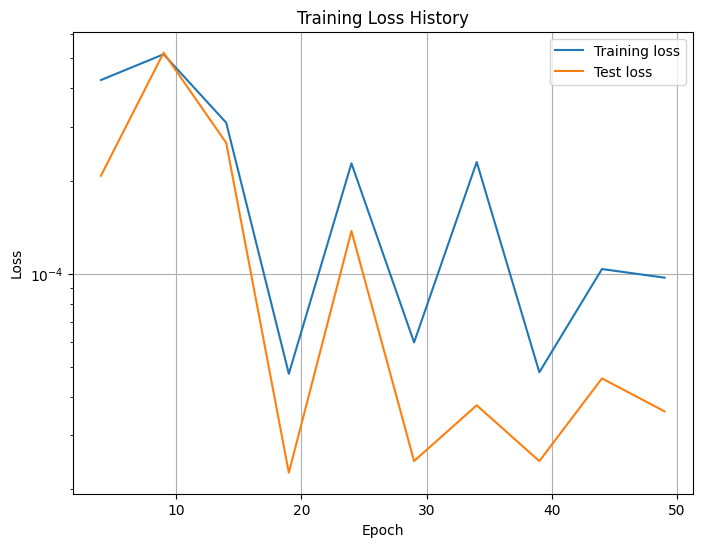

In [850]:
model.plot_losshistory()

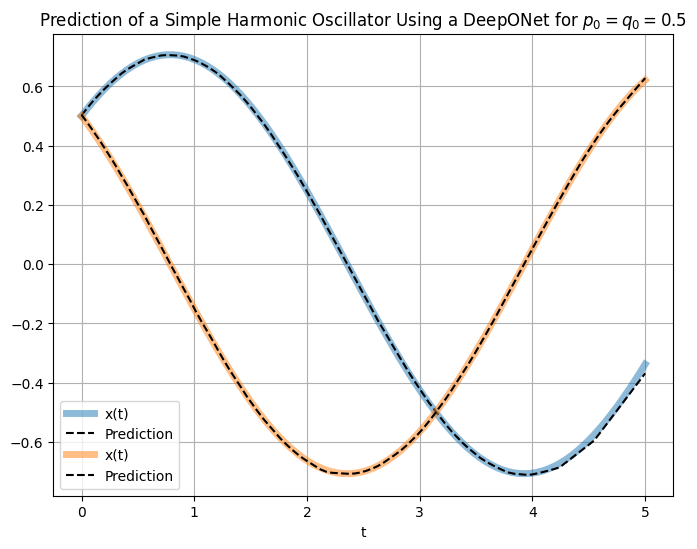

In [851]:
# Plot model prediction for one omega

# Get model prediction

t = np.linspace(0, 5, 100).reshape(-1, 1)
bv = np.array([[0.5, 0.5]])

pred = model.predict(bv, t)

# Get corresponding ground truth
ground_truth = analytic_solution(bv, t)


# Plot prediction vs. solution
fig, ax = plt.subplots(figsize=(8, 6))
for k in range(pred.shape[0]):
    ax.plot(t.flatten(), ground_truth[k,:].flatten(), label='x(t)', alpha=0.5, linewidth=5)
    ax.plot(t.flatten(), pred[k,:].flatten().tolist(), '--', label='Prediction', c='k')

ax.set_title('Prediction of a Simple Harmonic Oscillator Using a DeepONet for $p_0=q_0=0.5$')
ax.set_xlabel("t")
ax.legend()
ax.grid(True)
plt.show()